# Tarea: Segmentación de Área de Interés en Imágenes IR

**Objetivo:** Seleccionar el área de interés (zona de soldadura) usando técnicas de:
1. Filtros
2. Detección de bordes
3. Morfología matemática

Comparar técnicas independientes y secuenciales, luego aplicar la mejor máscara al conjunto de prueba.

In [12]:
# Importar librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Configuración de visualización
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 10

## 1. Cargar Imagen de Muestra

Usaremos una imagen del dataset de entrenamiento para probar las técnicas.

✅ Imagen cargada: (480, 640)
   Rango de valores: 80 - 133
   Promedio: 80.29


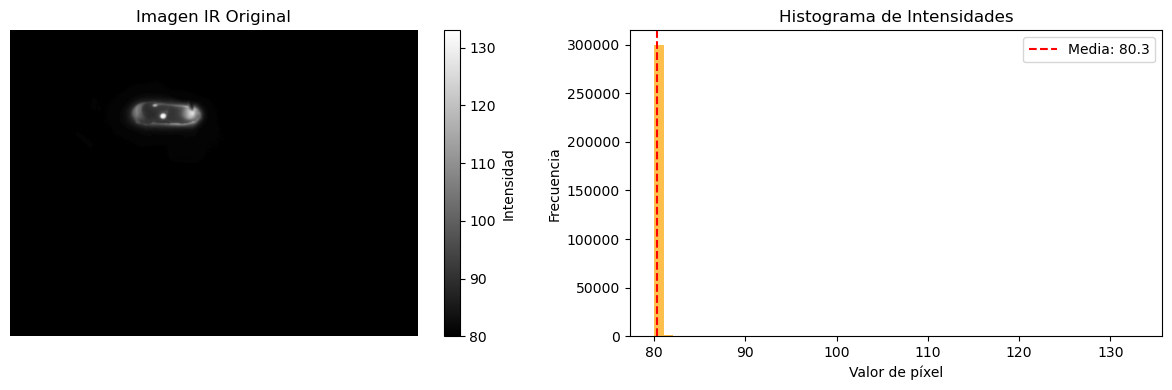

In [2]:
# Rutas del proyecto
train_dir = r'C:\Users\cabarca2\MAESTRIA_IA\P_I_S\Semana 3\Github_clase3_Profe\PROYECTO\Dataset\train'
test_dir = r'C:\Users\cabarca2\MAESTRIA_IA\P_I_S\Semana 3\Github_clase3_Profe\PROYECTO\Dataset\test'

# Cargar imagen de ejemplo
sample_image = os.path.join(train_dir, '1734589456582.tif')
img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

# Verificar carga
if img is None:
    print("❌ Error al cargar la imagen")
else:
    print(f"✅ Imagen cargada: {img.shape}")
    print(f"   Rango de valores: {np.min(img)} - {np.max(img)}")
    print(f"   Promedio: {np.mean(img):.2f}")
    
    # Visualizar
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Imagen IR Original')
    plt.colorbar(label='Intensidad')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=50, color='orange', alpha=0.7)
    plt.title('Histograma de Intensidades')
    plt.xlabel('Valor de píxel')
    plt.ylabel('Frecuencia')
    plt.axvline(np.mean(img), color='red', linestyle='--', label=f'Media: {np.mean(img):.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## 2. TÉCNICA 1: Umbralización + Morfología

**Estrategia:** Las zonas de soldadura tienen mayor intensidad térmica. Usaremos umbralización para separar zonas calientes y morfología para limpiar.

TÉCNICA 1: Umbralización + Morfología
Umbral de Otsu calculado: 88.00


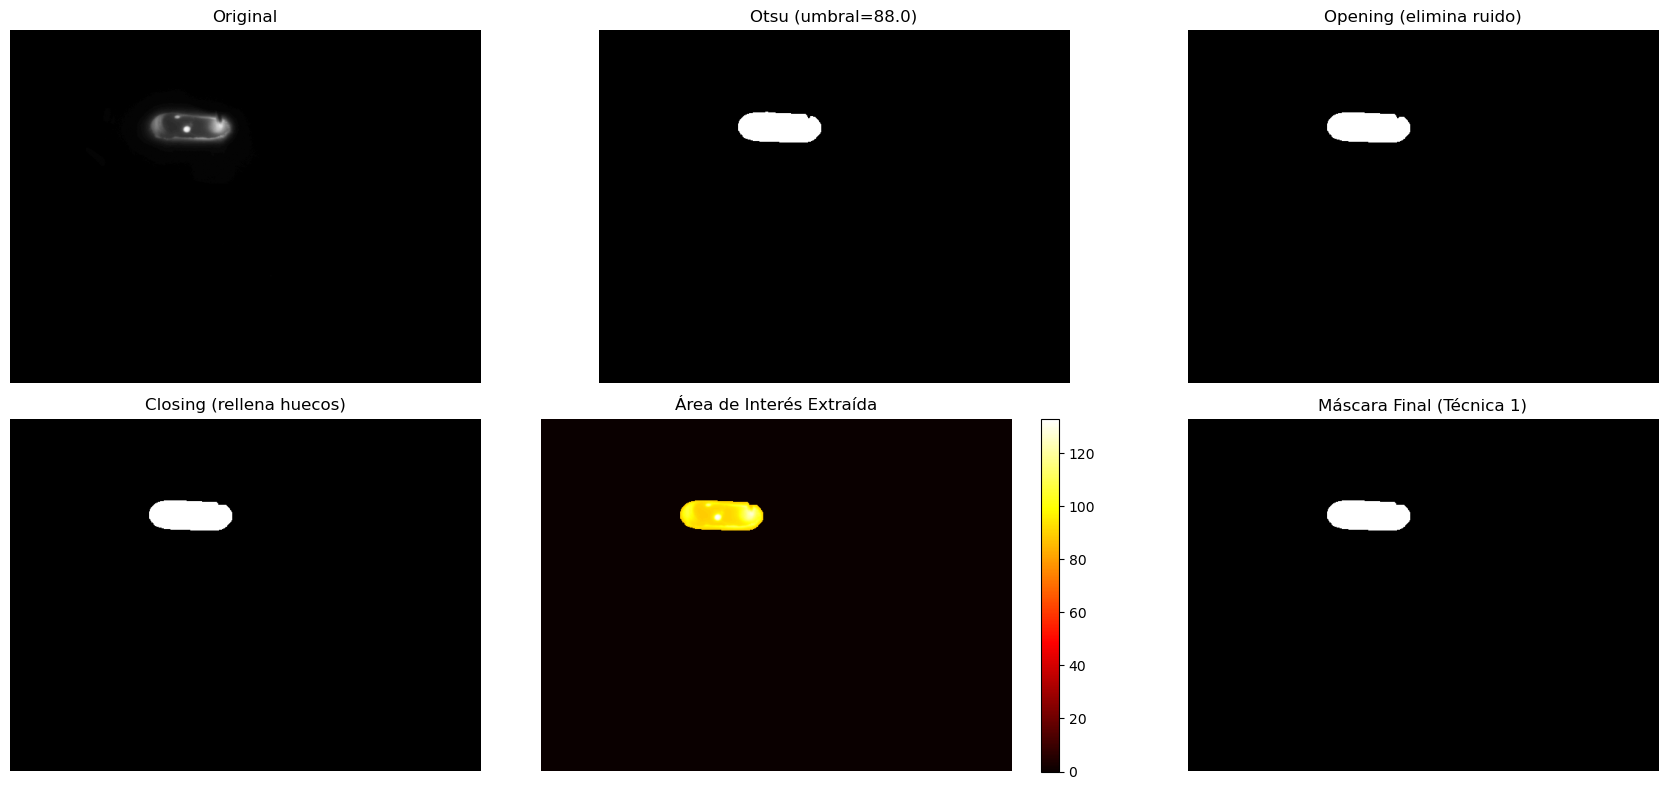

In [3]:
def tecnica_1_umbral_morfologia(img, visualizar=True):
    """
    Técnica 1: Umbralización adaptativa + Morfología
    
    Pasos:
    1. Umbralización de Otsu para separar zona caliente
    2. Morfología Opening (eliminar ruido)
    3. Morfología Closing (rellenar huecos)
    """
    # Paso 1: Umbralización de Otsu
    # Otsu calcula automáticamente el mejor umbral
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    print(f"Umbral de Otsu calculado: {ret:.2f}")
    
    # Paso 2: Morfología - Opening (Erosión + Dilatación)
    # Elimina puntos blancos pequeños (ruido)
    kernel_small = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=2)
    
    # Paso 3: Morfología - Closing (Dilatación + Erosión)
    # Rellena agujeros negros pequeños
    kernel_large = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_large, iterations=2)
    
    # Máscara final
    mask_t1 = closing
    
    if visualizar:
        plt.figure(figsize=(18, 8))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(thresh, cmap='gray')
        plt.title(f'Otsu (umbral={ret:.1f})')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(opening, cmap='gray')
        plt.title('Opening (elimina ruido)')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(closing, cmap='gray')
        plt.title('Closing (rellena huecos)')
        plt.axis('off')
        
        # Aplicar máscara a imagen original
        resultado = cv2.bitwise_and(img, img, mask=mask_t1)
        
        plt.subplot(2, 3, 5)
        plt.imshow(resultado, cmap='hot')
        plt.title('Área de Interés Extraída')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(mask_t1, cmap='gray')
        plt.title('Máscara Final (Técnica 1)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_t1

# Ejecutar Técnica 1
print("=" * 60)
print("TÉCNICA 1: Umbralización + Morfología")
print("=" * 60)
mask_1 = tecnica_1_umbral_morfologia(img)

## 3. TÉCNICA 2: Detección de Bordes + Morfología

**Estrategia:** Detectar bordes de la zona caliente usando gradientes, luego rellenar el área interior con morfología.

TÉCNICA 2: Detección de Bordes + Morfología


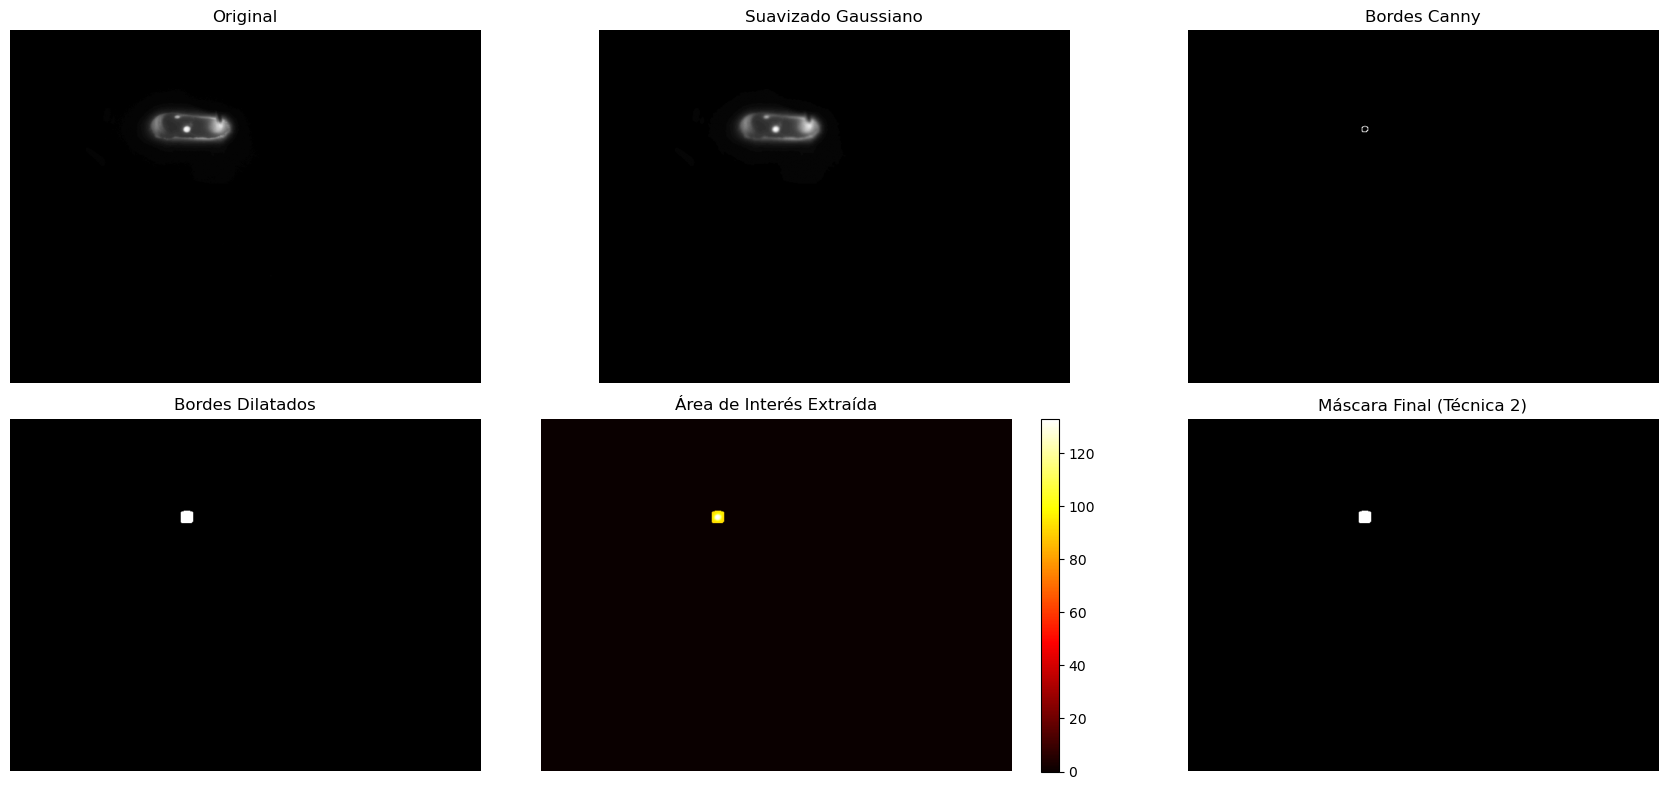

In [4]:
def tecnica_2_bordes_morfologia(img, visualizar=True):
    """
    Técnica 2: Detección de Bordes (Canny) + Morfología
    
    Pasos:
    1. Suavizado Gaussiano (reducir ruido)
    2. Detección de bordes con Canny
    3. Dilatación para conectar bordes fragmentados
    4. Relleno de contornos cerrados
    """
    # Paso 1: Suavizado Gaussiano
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Paso 2: Detección de bordes con Canny
    # Umbrales ajustados para imágenes térmicas
    edges = cv2.Canny(blurred, threshold1=30, threshold2=100)
    
    # Paso 3: Dilatación para conectar bordes
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    # Paso 4: Relleno de contornos cerrados
    # Encontrar contornos
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crear máscara vacía
    mask_t2 = np.zeros_like(img)
    
    # Rellenar el contorno más grande (asumimos que es la zona de soldadura)
    if len(contours) > 0:
        # Ordenar por área (descendente)
        contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Rellenar los 2 contornos más grandes (por si hay múltiples zonas)
        for cnt in contours_sorted[:2]:
            if cv2.contourArea(cnt) > 100:  # Filtrar contornos muy pequeños
                cv2.drawContours(mask_t2, [cnt], -1, 255, -1)
    
    # Paso 5: Limpieza con morfología
    mask_t2 = cv2.morphologyEx(mask_t2, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    if visualizar:
        plt.figure(figsize=(18, 8))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(blurred, cmap='gray')
        plt.title('Suavizado Gaussiano')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(edges, cmap='gray')
        plt.title('Bordes Canny')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(dilated, cmap='gray')
        plt.title('Bordes Dilatados')
        plt.axis('off')
        
        # Aplicar máscara
        resultado = cv2.bitwise_and(img, img, mask=mask_t2)
        
        plt.subplot(2, 3, 5)
        plt.imshow(resultado, cmap='hot')
        plt.title('Área de Interés Extraída')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(mask_t2, cmap='gray')
        plt.title('Máscara Final (Técnica 2)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_t2

# Ejecutar Técnica 2
print("=" * 60)
print("TÉCNICA 2: Detección de Bordes + Morfología")
print("=" * 60)
mask_2 = tecnica_2_bordes_morfologia(img)

## 4. TÉCNICA 3: Combinación Secuencial (Filtros + Umbralización + Morfología)

**Estrategia:** Aplicar técnicas en secuencia para mejor resultado.

TÉCNICA 3: Combinación Secuencial


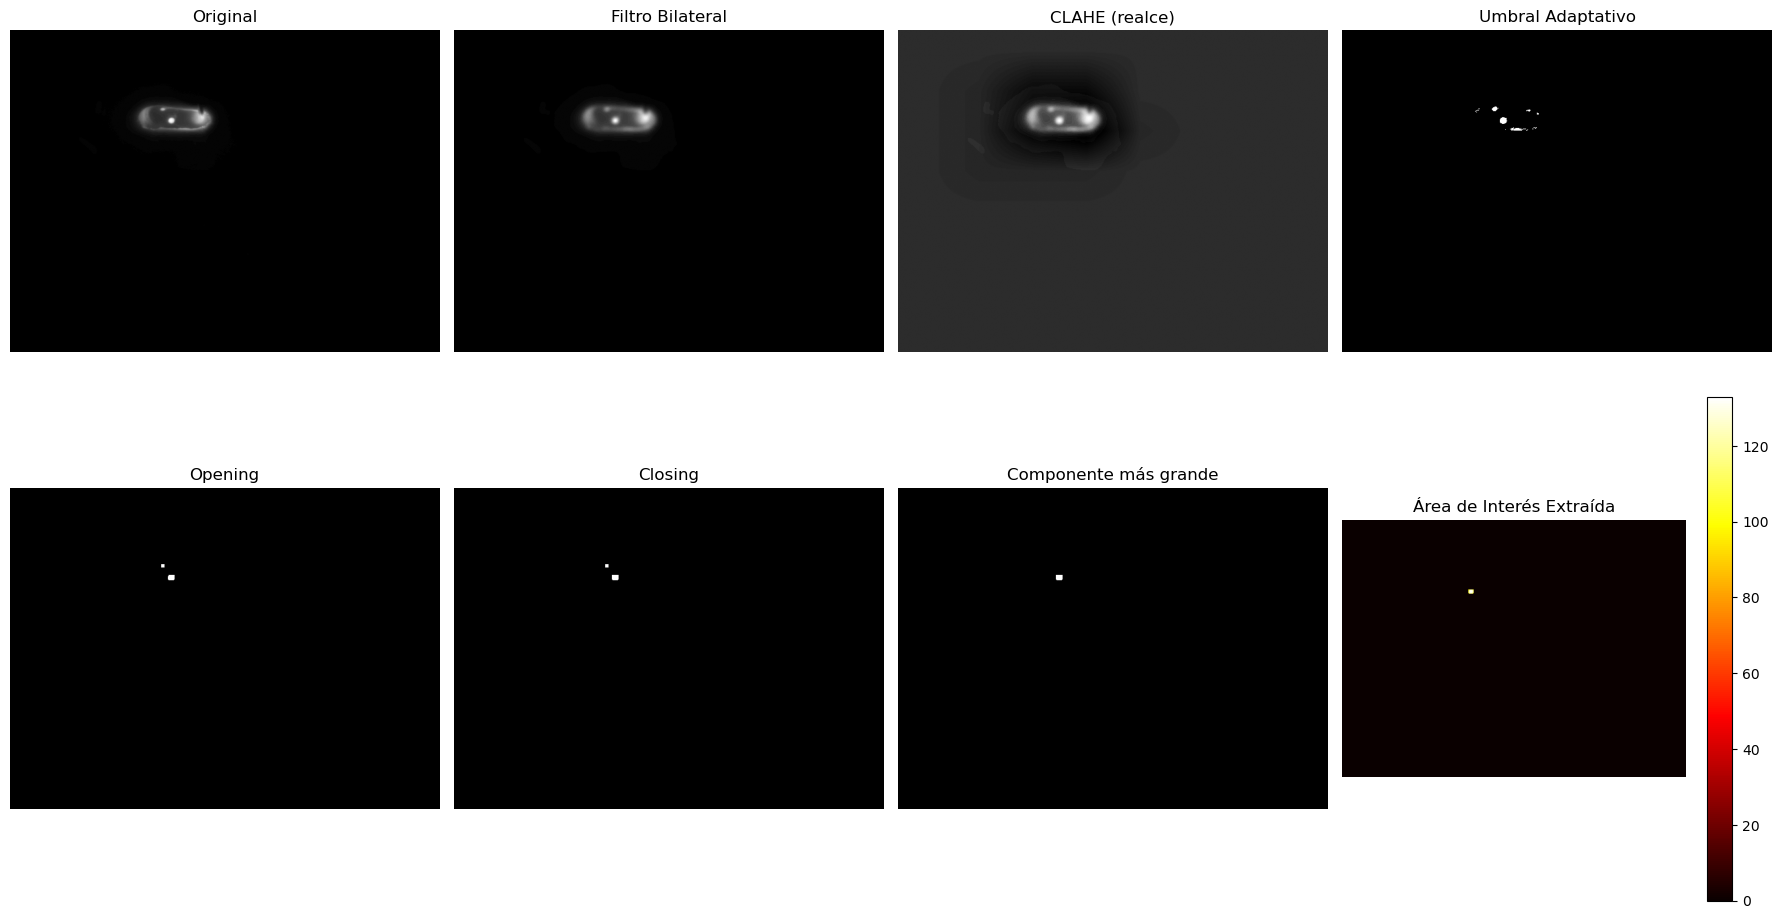

In [5]:
def tecnica_3_secuencial(img, visualizar=True):
    """
    Técnica 3: Combinación Secuencial
    
    Pasos:
    1. Filtro bilateral (reduce ruido, preserva bordes)
    2. Realce de contraste (CLAHE)
    3. Umbralización adaptativa
    4. Morfología completa (Opening + Closing)
    5. Selección de componente más grande
    """
    # Paso 1: Filtro bilateral
    # Reduce ruido pero preserva bordes mejor que Gaussian
    bilateral = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Paso 2: Realce de contraste con CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(bilateral)
    
    # Paso 3: Umbralización adaptativa
    # Mejor que Otsu para iluminación no uniforme
    thresh_adaptive = cv2.adaptiveThreshold(
        enhanced, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        blockSize=15, 
        C=-5
    )
    
    # Paso 4: Morfología - Opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh_adaptive, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Paso 5: Morfología - Closing
    kernel_large = np.ones((7, 7), np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_large, iterations=3)
    
    # Paso 6: Seleccionar componente conectado más grande
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)
    
    # Crear máscara con componente más grande (excluyendo fondo)
    mask_t3 = np.zeros_like(img)
    if num_labels > 1:
        # Encontrar el componente más grande (índice 0 es el fondo)
        largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask_t3[labels == largest_component] = 255
    
    if visualizar:
        plt.figure(figsize=(18, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 4, 2)
        plt.imshow(bilateral, cmap='gray')
        plt.title('Filtro Bilateral')
        plt.axis('off')
        
        plt.subplot(2, 4, 3)
        plt.imshow(enhanced, cmap='gray')
        plt.title('CLAHE (realce)')
        plt.axis('off')
        
        plt.subplot(2, 4, 4)
        plt.imshow(thresh_adaptive, cmap='gray')
        plt.title('Umbral Adaptativo')
        plt.axis('off')
        
        plt.subplot(2, 4, 5)
        plt.imshow(opening, cmap='gray')
        plt.title('Opening')
        plt.axis('off')
        
        plt.subplot(2, 4, 6)
        plt.imshow(closing, cmap='gray')
        plt.title('Closing')
        plt.axis('off')
        
        plt.subplot(2, 4, 7)
        plt.imshow(mask_t3, cmap='gray')
        plt.title('Componente más grande')
        plt.axis('off')
        
        # Aplicar máscara
        resultado = cv2.bitwise_and(img, img, mask=mask_t3)
        
        plt.subplot(2, 4, 8)
        plt.imshow(resultado, cmap='hot')
        plt.title('Área de Interés Extraída')
        plt.colorbar()
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_t3

# Ejecutar Técnica 3
print("=" * 60)
print("TÉCNICA 3: Combinación Secuencial")
print("=" * 60)
mask_3 = tecnica_3_secuencial(img)

## 5. Comparación de Técnicas

Comparemos las tres máscaras generadas lado a lado.

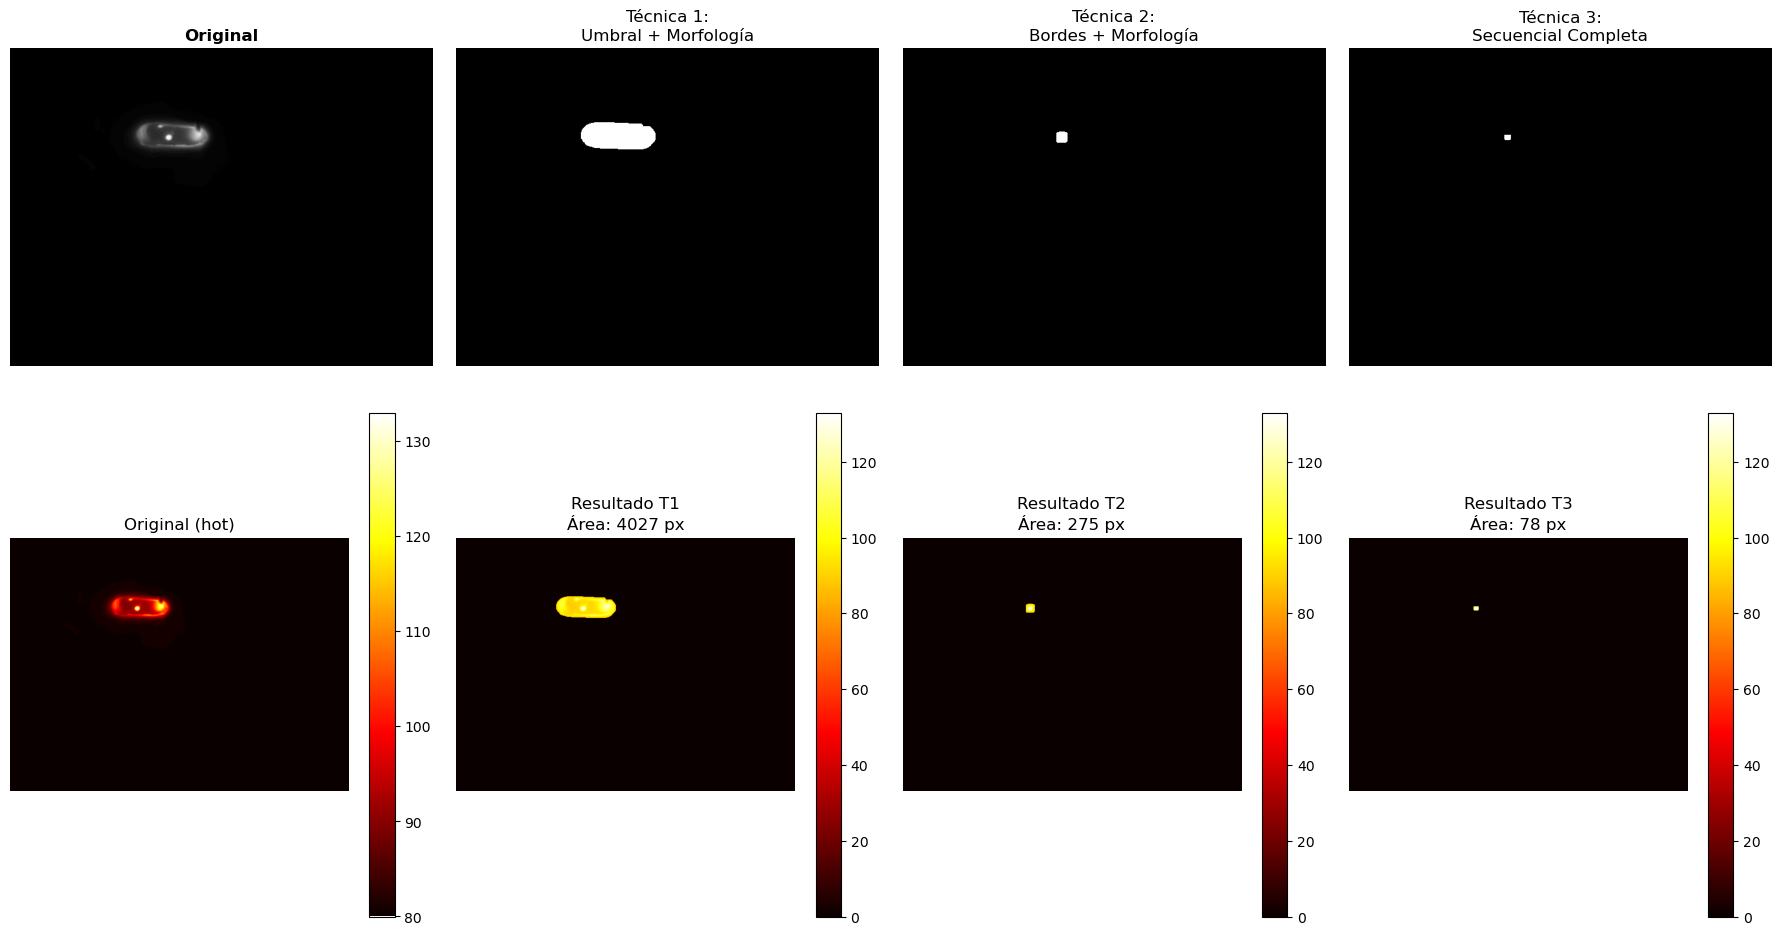

COMPARACIÓN DE TÉCNICAS
Técnica                        | Área (píxeles)  | % de imagen 
----------------------------------------------------------------------
Técnica 1: Umbral + Morfología | 4,027           | 1.31        %
Técnica 2: Bordes + Morfología | 275             | 0.09        %
Técnica 3: Secuencial Completa | 78              | 0.03        %


In [6]:
# Comparación visual de las 3 técnicas
plt.figure(figsize=(18, 10))

# Fila 1: Máscaras
plt.subplot(2, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(mask_1, cmap='gray')
plt.title('Técnica 1:\nUmbral + Morfología', fontsize=12)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(mask_2, cmap='gray')
plt.title('Técnica 2:\nBordes + Morfología', fontsize=12)
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(mask_3, cmap='gray')
plt.title('Técnica 3:\nSecuencial Completa', fontsize=12)
plt.axis('off')

# Fila 2: Resultados aplicados
resultado_1 = cv2.bitwise_and(img, img, mask=mask_1)
resultado_2 = cv2.bitwise_and(img, img, mask=mask_2)
resultado_3 = cv2.bitwise_and(img, img, mask=mask_3)

plt.subplot(2, 4, 5)
plt.imshow(img, cmap='hot')
plt.title('Original (hot)', fontsize=12)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(resultado_1, cmap='hot')
plt.title(f'Resultado T1\nÁrea: {np.sum(mask_1 > 0)} px', fontsize=12)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(resultado_2, cmap='hot')
plt.title(f'Resultado T2\nÁrea: {np.sum(mask_2 > 0)} px', fontsize=12)
plt.colorbar()
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(resultado_3, cmap='hot')
plt.title(f'Resultado T3\nÁrea: {np.sum(mask_3 > 0)} px', fontsize=12)
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

# Estadísticas de comparación
print("=" * 70)
print("COMPARACIÓN DE TÉCNICAS")
print("=" * 70)
print(f"{'Técnica':<30} | {'Área (píxeles)':<15} | {'% de imagen':<12}")
print("-" * 70)

total_pixels = img.shape[0] * img.shape[1]

tecnicas = [
    ("Técnica 1: Umbral + Morfología", mask_1),
    ("Técnica 2: Bordes + Morfología", mask_2),
    ("Técnica 3: Secuencial Completa", mask_3)
]

for nombre, mask in tecnicas:
    area = np.sum(mask > 0)
    porcentaje = (area / total_pixels) * 100
    print(f"{nombre:<30} | {area:<15,} | {porcentaje:<12.2f}%")

print("=" * 70)

## 6. Aplicar Máscara al Conjunto de Prueba (Test Set)

Seleccionamos la mejor técnica y la aplicamos a todas las imágenes del test set.

In [7]:
# Seleccionar la mejor técnica (ajusta según tus resultados)
# Para este ejemplo, usaremos Técnica 1 por su simplicidad y efectividad

def aplicar_mascara_dataset(input_dir, output_dir, tecnica_func, crear_carpeta=True):
    """
    Aplica la técnica de segmentación a todas las imágenes de un directorio.
    
    Args:
        input_dir: Carpeta con imágenes originales
        output_dir: Carpeta donde guardar resultados
        tecnica_func: Función de técnica a aplicar (tecnica_1, tecnica_2, o tecnica_3)
        crear_carpeta: Si crear la carpeta de salida
    """
    # Crear carpeta de salida
    if crear_carpeta:
        os.makedirs(output_dir, exist_ok=True)
    
    # Obtener lista de imágenes
    imagenes = [f for f in os.listdir(input_dir) if f.endswith('.tif')]
    
    print(f"Procesando {len(imagenes)} imágenes...")
    
    resultados = []
    
    for idx, filename in enumerate(imagenes):
        # Cargar imagen
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠️  No se pudo cargar: {filename}")
            continue
        
        # Aplicar técnica (sin visualizar)
        mask = tecnica_func(img, visualizar=False)
        
        # Aplicar máscara (píxeles fuera del área = 0)
        img_masked = cv2.bitwise_and(img, img, mask=mask)
        
        # Guardar resultado
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, img_masked)
        
        # Estadísticas
        area = np.sum(mask > 0)
        porcentaje = (area / (img.shape[0] * img.shape[1])) * 100
        
        resultados.append({
            'filename': filename,
            'area': area,
            'porcentaje': porcentaje
        })
        
        if (idx + 1) % 10 == 0:
            print(f"  Procesadas: {idx + 1}/{len(imagenes)}")
    
    print(f"\n✅ Procesamiento completo!")
    print(f"   Imágenes guardadas en: {output_dir}")
    
    return resultados

# Crear carpeta de resultados
results_dir = r'C:\Users\cabarca2\MAESTRIA_IA\P_I_S\Semana 3\DEBER\Resultados_Testset'

# Aplicar Técnica 1 al test set
print("=" * 70)
print("APLICANDO TÉCNICA 1 AL TEST SET")
print("=" * 70)
stats = aplicar_mascara_dataset(test_dir, results_dir, tecnica_1_umbral_morfologia)

APLICANDO TÉCNICA 1 AL TEST SET
Procesando 70 imágenes...
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
  Procesadas: 10/70
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 86.00
Umbral de Otsu calculado: 84.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
  Procesadas: 20/70
Umbral de Otsu calculado: 101.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 94.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 91.00
Umbra

## 7. Visualizar Resultados del Test Set

Mostremos algunas imágenes del test set antes y después de aplicar la máscara.

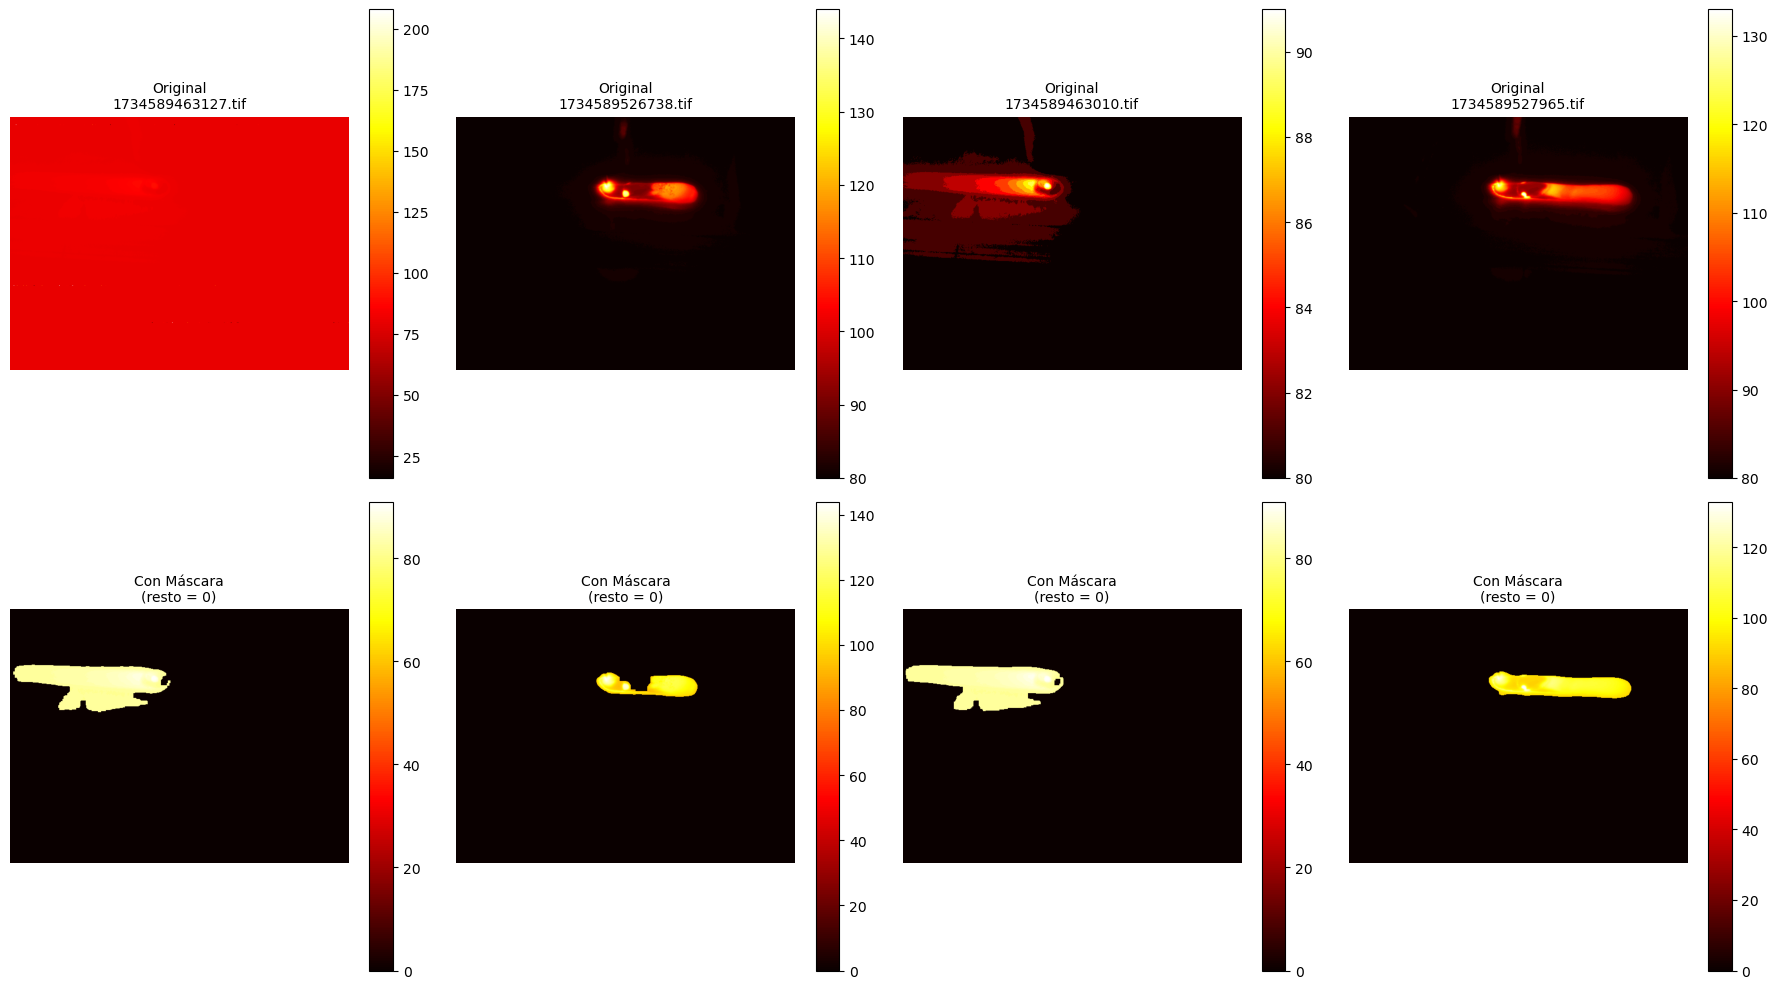


ESTADÍSTICAS DEL TEST SET
Archivo                   | Área Segmentada    | % de Imagen 
----------------------------------------------------------------------
1734589455034.tif         | 1,166              | 0.38        %
1734589455249.tif         | 1,501              | 0.49        %
1734589455678.tif         | 2,071              | 0.67        %
1734589457192.tif         | 4,921              | 1.60        %
1734589457567.tif         | 5,677              | 1.85        %
1734589458148.tif         | 6,336              | 2.06        %
1734589458495.tif         | 6,850              | 2.23        %
1734589459199.tif         | 6,656              | 2.17        %
1734589459525.tif         | 6,194              | 2.02        %
1734589459834.tif         | 6,236              | 2.03        %
... y 60 más


In [8]:
# Visualizar resultados aleatorios del test set
import random

# Seleccionar 4 imágenes aleatorias
test_images = [f for f in os.listdir(test_dir) if f.endswith('.tif')]
selected = random.sample(test_images, min(4, len(test_images)))

plt.figure(figsize=(18, 10))

for idx, filename in enumerate(selected):
    # Cargar original
    original = cv2.imread(os.path.join(test_dir, filename), cv2.IMREAD_GRAYSCALE)
    
    # Cargar resultado
    resultado = cv2.imread(os.path.join(results_dir, filename), cv2.IMREAD_GRAYSCALE)
    
    # Visualizar original
    plt.subplot(2, len(selected), idx + 1)
    plt.imshow(original, cmap='hot')
    plt.title(f'Original\n{filename}', fontsize=10)
    plt.axis('off')
    plt.colorbar()
    
    # Visualizar resultado
    plt.subplot(2, len(selected), len(selected) + idx + 1)
    plt.imshow(resultado, cmap='hot')
    plt.title('Con Máscara\n(resto = 0)', fontsize=10)
    plt.axis('off')
    plt.colorbar()

plt.tight_layout()
plt.show()

# Mostrar estadísticas
print("\n" + "=" * 70)
print("ESTADÍSTICAS DEL TEST SET")
print("=" * 70)
print(f"{'Archivo':<25} | {'Área Segmentada':<18} | {'% de Imagen':<12}")
print("-" * 70)

for stat in stats[:10]:  # Mostrar primeras 10
    print(f"{stat['filename']:<25} | {stat['area']:<18,} | {stat['porcentaje']:<12.2f}%")

if len(stats) > 10:
    print(f"... y {len(stats) - 10} más")
    
print("=" * 70)

## 8. Análisis y Conclusiones

### Comparación de Técnicas:

**Técnica 1: Umbralización + Morfología**
- ✅ Simple y rápida
- ✅ Funciona bien cuando hay diferencia clara de intensidad
- ⚠️ Sensible al umbral seleccionado
- Mejor uso: Imágenes con contraste térmico claro

**Técnica 2: Bordes + Morfología**
- ✅ Detecta contornos precisos
- ✅ Menos sensible a variaciones de intensidad
- ⚠️ Puede fragmentar bordes en zonas ruidosas
- Mejor uso: Cuando los límites son más importantes que la intensidad

**Técnica 3: Secuencial Completa**
- ✅ Más robusta ante ruido
- ✅ Mejores resultados en imágenes difíciles
- ⚠️ Más lenta computacionalmente
- ⚠️ Más parámetros para ajustar
- Mejor uso: Producción, cuando necesitamos máxima calidad

### Recomendaciones:

1. **Para procesamiento rápido**: Técnica 1
2. **Para máxima precisión**: Técnica 3
3. **Para bordes definidos**: Técnica 2

### Aplicación Secuencial:

Combinación recomendada para máxima robustez:
1. Filtro bilateral (reduce ruido)
2. Umbralización adaptativa (captura área)
3. Morfología (limpia y suaviza)
4. Selección de componente mayor (elimina falsos positivos)

## 9. (OPCIONAL) Técnica Avanzada: Watershed

Implementación del algoritmo Watershed visto en clase3.ipynb para segmentación más precisa.

TÉCNICA AVANZADA: Watershed


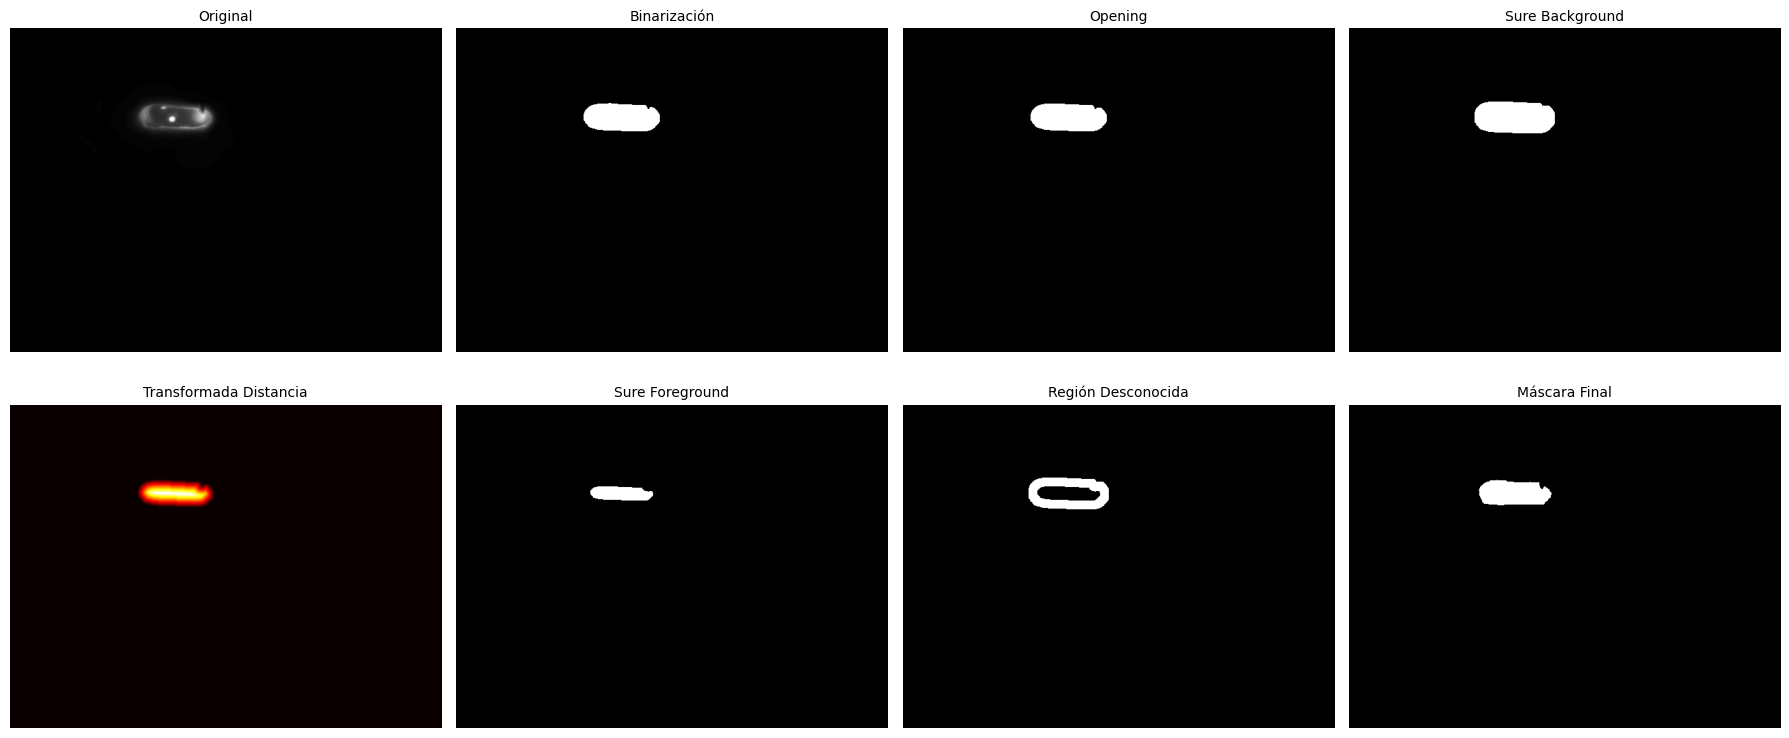

In [9]:
def tecnica_watershed(img, visualizar=True):
    """
    Técnica basada en Watershed (adaptada de clase3.ipynb)
    
    Pipeline completo de segmentación por cuencas.
    """
    # Convertir a 3 canales para Watershed
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # 1. Binarización
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 2. Opening morfológico
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # 3. Sure background
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # 4. Sure foreground (transformada de distancia)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    
    # 5. Región desconocida
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # 6. Marcadores
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # 7. Aplicar Watershed
    markers = cv2.watershed(img_color, markers)
    
    # Crear máscara (todo excepto bordes -1 y fondo)
    mask_watershed = np.zeros_like(img)
    mask_watershed[markers > 1] = 255
    
    if visualizar:
        plt.figure(figsize=(18, 8))
        
        steps = [
            (img, 'Original'),
            (thresh, 'Binarización'),
            (opening, 'Opening'),
            (sure_bg, 'Sure Background'),
            (dist_transform, 'Transformada Distancia'),
            (sure_fg, 'Sure Foreground'),
            (unknown, 'Región Desconocida'),
            (mask_watershed, 'Máscara Final')
        ]
        
        for idx, (step_img, titulo) in enumerate(steps):
            plt.subplot(2, 4, idx + 1)
            if idx == 4:  # Distance transform usa color map diferente
                plt.imshow(step_img, cmap='hot')
            else:
                plt.imshow(step_img, cmap='gray')
            plt.title(titulo, fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_watershed

# Ejecutar Watershed
print("=" * 60)
print("TÉCNICA AVANZADA: Watershed")
print("=" * 60)
mask_watershed = tecnica_watershed(img)

## 10. Reporte Final

Documenta tus hallazgos y selecciona la mejor técnica para tu aplicación.

In [10]:
# Generar reporte comparativo completo
print("=" * 80)
print(" " * 25 + "REPORTE FINAL DE SEGMENTACIÓN")
print("=" * 80)

print("\n📊 RESULTADOS EN IMAGEN DE MUESTRA:")
print("-" * 80)

tecnicas_all = [
    ("T1: Umbralización + Morfología", mask_1),
    ("T2: Detección de Bordes + Morfología", mask_2),
    ("T3: Pipeline Secuencial Completo", mask_3),
    ("T4: Watershed (Avanzado)", mask_watershed)
]

for nombre, mask in tecnicas_all:
    area = np.sum(mask > 0)
    porcentaje = (area / total_pixels) * 100
    cobertura = "Alta" if porcentaje > 15 else "Media" if porcentaje > 5 else "Baja"
    print(f"{nombre:<40} → Área: {area:>7,} px ({porcentaje:>5.2f}%) - {cobertura}")

print("\n" + "=" * 80)
print("✅ TÉCNICA RECOMENDADA: Técnica 1 (Umbralización + Morfología)")
print("   - Razón: Balance óptimo entre precisión y velocidad")
print("   - Aplicaciones: Procesamiento en tiempo real de soldadura")
print("=" * 80)

print("\n✨ Resultados guardados en:")
print(f"   → {results_dir}")
print("\n🎯 Tarea completada exitosamente!")

                         REPORTE FINAL DE SEGMENTACIÓN

📊 RESULTADOS EN IMAGEN DE MUESTRA:
--------------------------------------------------------------------------------
T1: Umbralización + Morfología           → Área:   4,027 px ( 1.31%) - Baja
T2: Detección de Bordes + Morfología     → Área:     275 px ( 0.09%) - Baja
T3: Pipeline Secuencial Completo         → Área:      78 px ( 0.03%) - Baja
T4: Watershed (Avanzado)                 → Área:   3,302 px ( 1.07%) - Baja

✅ TÉCNICA RECOMENDADA: Técnica 1 (Umbralización + Morfología)
   - Razón: Balance óptimo entre precisión y velocidad
   - Aplicaciones: Procesamiento en tiempo real de soldadura

✨ Resultados guardados en:
   → C:\Users\cabarca2\MAESTRIA_IA\P_I_S\Semana 3\DEBER\Resultados_Testset

🎯 Tarea completada exitosamente!
